## Data

The MNIST Dataset (as a CSV file for simplicity) can be found at [https://www.kaggle.com/datasets/oddrationale/mnist-in-csv/data](https://www.kaggle.com/datasets/oddrationale/mnist-in-csv/data)

First, we must read the data from the CSV files. You can open the CSV files to see how the data is formatted: the first column is the image's label, and the remaining columns are the pixels for the image

In [1]:
import csv
from PIL import Image

def read_data(file):
    data = [[], [], []]
    with open(file, newline='') as csvFile:
        reader = csv.reader(csvFile)
        for row in reader:

            # skip header row
            if reader.line_num == 1:
                continue

            # first column is label
            data[0].append(int(row[0]))

            # remaining columns are image data
            imageData = [int(x) for x in row[1:]]
            normalizedImageData = [x / 255 for x in imageData]
            data[1].append(normalizedImageData)

            # convert to image for reference
            image = Image.new('L', (28, 28))
            image.putdata(imageData)
            data[2].append(image)

    return data

# contains (label, imageData, and image)
trainingData = read_data('mnist_train.csv')
testData = read_data('mnist_test.csv')


Now we can preview some of the images using matplotlib

`pip install matplotlib`

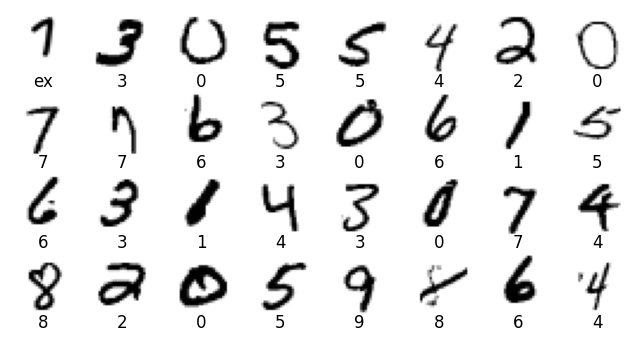

In [318]:
import matplotlib.pyplot as plt
import random

width = 8
height = 4


plt.figure(figsize=(width, height))
for idx in range(1, width * height):
    img = random.randint(0, len(trainingData[0]) - 1)
    plt.subplot(height, width, idx + 1)
    plt.imshow(trainingData[2][img], cmap='binary')
    plt.title(trainingData[0][img], y=-0.3)
    plt.axis('off')

plt.subplot(height, width, 1)
plt.imshow(Image.open('small_image.png'), cmap='binary')
plt.title('ex', y=-0.3)
plt.axis('off')

plt.show()

## The model

Now let's create the model that we're going to train. We will use scikit-learn
to create our model. This type of model is called a Dense Neural Network or
Fully Connected Neural Network (FCNN).

`pip install scikit-learn`

In [170]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(1000,),
    solver="adam",
    verbose=True,
)

mlp.fit(trainingData[1], trainingData[0])

Iteration 1, loss = 0.26576728
Iteration 2, loss = 0.10374298
Iteration 3, loss = 0.06581677
Iteration 4, loss = 0.04717509
Iteration 5, loss = 0.03455899
Iteration 6, loss = 0.02448677
Iteration 7, loss = 0.01902821
Iteration 8, loss = 0.01422570
Iteration 9, loss = 0.01050008
Iteration 10, loss = 0.00894831
Iteration 11, loss = 0.00691040
Iteration 12, loss = 0.00555020
Iteration 13, loss = 0.00306076
Iteration 14, loss = 0.00242775
Iteration 15, loss = 0.00228410
Iteration 16, loss = 0.01763918
Iteration 17, loss = 0.01354212
Iteration 18, loss = 0.00494389
Iteration 19, loss = 0.00271486
Iteration 20, loss = 0.00163100
Iteration 21, loss = 0.00138709
Iteration 22, loss = 0.00116998
Iteration 23, loss = 0.00110090
Iteration 24, loss = 0.00105571
Iteration 25, loss = 0.00103056
Iteration 26, loss = 0.00099205
Iteration 27, loss = 0.00096285
Iteration 28, loss = 0.00093435
Iteration 29, loss = 0.00090961
Iteration 30, loss = 0.00088508
Iteration 31, loss = 0.00086146
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(1000,), verbose=True)

In [171]:
correct = 0
for idx, guess in enumerate(mlp.predict(testData[1])):
    # print(f'{guess}: {trainingData[0][idx]}')
    if guess == testData[0][idx]: correct += 1

print(f'{correct}/{len(testData[0])}: {100 * correct/len(testData[0]):.2f}%')

9841/10000: 98.41%


### Using Keras

To create a more sophisticated model, we can use keras with the pyTorch backend.

```
pip install keras
pip install torch torchvision torchaudio
```

To set torch as the backend for keras, navigate to `~/.keras/keras.json` and set
`"backend": "torch"`. If you try to import keras before configuring the backend,
you will have to restart the Python kernel.

In [ ]:
from keras import layers, models

model = models.Sequential()
model.add(layers.InputLayer((784,)))
# model.add(layers.Conv2D(10, 4, input_shape=(28, 28, 1), activation='relu'))
# model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

AttributeError: module 'keras.api.layers' has no attribute 'Inputs'

In [ ]:
# create torch datasets
keras_x_val = trainingData[1][-10000:]
keras_y_val = trainingData[0][-10000:]
keras_x_train = trainingData[1][:-10000]
keras_y_train = trainingData[0][:-10000]


In [ ]:
from keras import optimizers

model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.SGD(learning_rate=0.1),
    metrics=["acc"],
)

history = model.fit(
    keras_x_train,
    keras_y_train,
    batch_size=64,
    epochs=2,
    validation_data=(keras_x_val, keras_y_val),
)


: 

## Writing our own numbers

The following script lets you draw on a canvas. Then, you can have your model guess what number you wrote!

In [366]:
from ipycanvas import Canvas

canvasSize = 300
strokeSize = 8

canvas: Canvas = Canvas(width=canvasSize, height=canvasSize)
canvas.fill_style = "black"
canvas.stroke_style = 'white'
canvas.line_width = 24
canvas.line_cap = 'round'
canvas.line_join = 'round'
canvas.fill_rect(0, 0, canvasSize, canvasSize)

mouseDown = False
points = []

def handle_mouse_down(x, y):
    global mouseDown
    mouseDown = True
    canvas.move_to(x, y)


def handle_mouse_up(x, y):
    global mouseDown
    mouseDown = False
    canvas.begin_path()
    canvas.line_to(x, y)
    canvas.stroke()

def handle_mouse_move(x, y):
    if mouseDown:
        canvas.line_to(x, y)
        canvas.stroke()
        fill = canvas.create_radial_gradient(
            x, y, strokeSize / 2, x, y, strokeSize, [(0, "#FFFFFFFF"), (1, "#FFFFFF00")]
        )

        canvas.fill_style = fill
        # canvas.fill_circle(x, y, strokeSize)


def save_to_file(*args, **kwargs):
    canvas.to_file("my_image.png")


canvas.on_mouse_down(handle_mouse_down)
canvas.on_mouse_up(handle_mouse_up)
canvas.on_mouse_move(handle_mouse_move)

canvas.observe(save_to_file, "image_data")
canvas.sync_image_data = True

canvas

Canvas(height=300, sync_image_data=True, width=300)

The following code snippit will sometimes use an outdated version of the canvas. If the preview does not match what you drew, just run it again.

In [368]:
from ipywidgets import Image as Img

# open image as a 28x28 grayscale image
image = Image.open('my_image.png').resize((28, 28)).convert(mode='L')
# save image for previewing
image.save('small_image.png')
imageData = [x / 255 for x in image.getdata()]
print(mlp.predict([image.getdata()]))

imagePreview = Img.from_file("small_image.png")

preview: Canvas = Canvas(width=(28 * 4), height=(28 * 4))
preview.draw_image(imagePreview, 0, 0, 28 * 4, 28 * 4)
preview

[5]


Canvas(height=112, width=112)